In [98]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

Read data

In [76]:
# Read the shapefile
chicago = gpd.read_file('data/chicago_tract.shp')
chicago['GEOID'] = chicago['GEOID'].astype(str)
chicago['centroid'] = chicago['geometry'].centroid

# Read the CSV file
od = pd.read_csv('data/il_od_main_JT00_2021.csv')

# Extract the first 11 characters of 'w_geocode' and 'h_geocode' as 'w_tract' and 'h_tract'
od['w_id'] = od['w_geocode'].astype(str).str[:11] 
od['h_id'] = od['h_geocode'].astype(str).str[:11]

# Filter for rows where both 'w_county' and 'h_county' are in 'GEOID' column of 'chicago'
od = od[(od['w_id'].isin(chicago['GEOID'])) & (od['h_id'].isin(chicago['GEOID']))]
od = od.groupby(['w_id', 'h_id']).agg({'S000': 'sum'}).reset_index()
od = od[['w_id', 'h_id', 'S000']]
od

,w_id,h_id,S000
0,17031010100,17031010100,28
1,17031010100,17031010201,9
2,17031010100,17031010202,1
3,17031010100,17031010300,3
4,17031010100,17031010400,2
...,...,...,...
139312,17031980100,17031843300,1
139313,17031980100,17031843400,2
139314,17031980100,17031843600,3
139315,17031980100,17031843800,5


In [78]:
od_origin = od.merge(chicago[['GEOID', 'centroid']], left_on='w_id', right_on='GEOID', how='left')
od_destination = od.merge(chicago[['GEOID', 'centroid']], left_on='h_id', right_on='GEOID', how='left')

# Convert the merged DataFrames to GeoDataFrames
gdf_origin = gpd.GeoDataFrame(od_origin, geometry='centroid', crs=chicago.crs)
gdf_destination = gpd.GeoDataFrame(od_destination, geometry='centroid', crs=chicago.crs)

# Ensure the GeoDataFrames have the same CRS
projected_crs = 'EPSG:32633'
gdf_origin = gdf_origin.to_crs(projected_crs)
gdf_destination = gdf_destination.to_crs(projected_crs)

# Calculate the distance between origin and destination using the Haversine distance
gdf_origin['distance'] = gdf_origin['centroid'].distance(gdf_destination['centroid'])

# Link the distances back to the original 'od' DataFrame
od['distance'] = gdf_origin['distance']

od_w = od.groupby('w_id').agg({'S000': 'sum'}).reset_index()
od_w = od_w.rename(columns={'S000': 'S000_w'})
od_h = od.groupby('h_id').agg({'S000': 'sum'}).reset_index()
od_h = od_h.rename(columns={'S000': 'S000_h'})
od = od.merge(od_w[['w_id', 'S000_w']], on='w_id')
od = od.merge(od_h[['h_id', 'S000_h']], on='h_id')

od

,w_id,h_id,S000,distance,S000_w,S000_h
0,17031010100,17031010100,28,0.000000,202,993
1,17031010202,17031010100,7,937.014849,450,993
2,17031010300,17031010100,26,941.525243,722,993
3,17031010400,17031010100,9,2925.667637,1790,993
4,17031010503,17031010100,3,3463.634411,132,993
...,...,...,...,...,...,...
139312,17031840400,17031381700,1,6654.315624,1838,52
139313,17031841900,17031381700,1,10236.866706,11370,52
139314,17031843000,17031381700,1,15287.499288,555,52
139315,17031843100,17031381700,2,12554.696503,1281,52


Fit beta

In [100]:
p_w = np.array(od['S000_w'])
p_h = np.array(od['S000_h'])
distances = np.array(od['distance']) / 1000
effects = np.array(od['S000'])

# Define the Gaussian decay function
def gaussian_decay(x, g, beta):
    return g * p_w * p_h * np.exp(-beta * x)

# Fit the curve to your data
popt, pcov = curve_fit(gaussian_decay, distances, effects, bounds=(0, np.inf))
# The optimal value for the distance decay constant (beta)
y_pred = gaussian_decay(distances, *popt)
popt, r2_score(effects, y_pred)

(array([1.84182621e-06, 1.08481060e-02]), 0.8715478208667575)

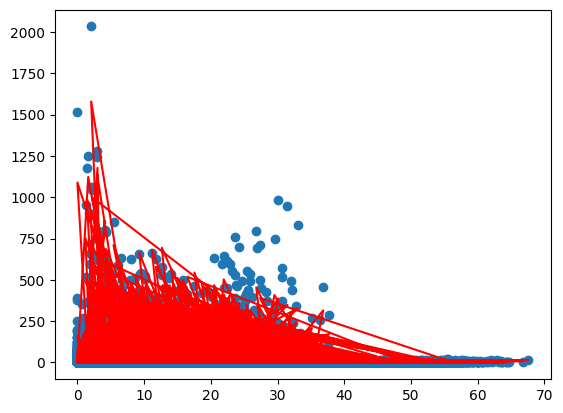

In [106]:
plt.scatter(distances, effects)
plt.plot(distances, gaussian_decay(distances, *popt), 'r-')